In [1]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
%pylab inline 
import statsmodels.formula.api as smf
# plt.style.use('fivethirtyeight')
import community

Populating the interactive namespace from numpy and matplotlib


In [4]:
june = pd.read_csv( '2014-06 - Citi Bike trip data.csv')
stations = pd.read_csv( 'citibike-locations.csv')

In [5]:
june.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,520,2014-06-01 00:00:02,2014-06-01 00:08:42,358,Christopher St & Greenwich St,40.732916,-74.007114,426,West St & Chambers St,40.717548,-74.013221,18840,Subscriber,1979,1
1,520,2014-06-01 00:00:27,2014-06-01 00:09:07,335,Washington Pl & Broadway,40.729039,-73.994046,265,Stanton St & Chrystie St,40.722293,-73.991475,17442,Customer,\N,0
2,414,2014-06-01 00:00:32,2014-06-01 00:07:26,439,E 4 St & 2 Ave,40.726281,-73.989780,368,Carmine St & 6 Ave,40.730386,-74.002150,16447,Subscriber,1980,1
3,310,2014-06-01 00:00:34,2014-06-01 00:05:44,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,18218,Subscriber,1984,1
4,457,2014-06-01 00:00:35,2014-06-01 00:08:12,352,W 56 St & 6 Ave,40.763406,-73.977225,305,E 58 St & 3 Ave,40.760958,-73.967245,18115,Subscriber,1969,1


In [6]:
june.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [7]:
# Grouping by Start and End Station
june_averaged = june.groupby(['start station id', 'end station id']).count()

In [8]:
june_averaged = june_averaged.reset_index()

In [15]:
june_averaged = june_averaged[['start station id', 'end station id', 'tripduration']]

In [16]:
juneGraph = nx.DiGraph()
for i in june_averaged.index:
    juneGraph.add_edge(june_averaged['start station id'][i], june['end station id'][i])

In [17]:
stations.head()

,the_geom,objectid,station_id,lat,lon,borough,name,cartodb_id,created_at,updated_at
0,0101000020E6100000899FCD819C7F52C097C807B43562...,1,72,40.767272,-73.993929,Manhattan,72,1,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
1,0101000020E61000009C8FB6336D8052C0078EEFB40B5C...,2,79,40.719116,-74.006667,Manhattan,79,2,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
2,0101000020E61000006C89E1AF028052C0A517FD7B075B...,3,82,40.711174,-74.000165,Manhattan,82,3,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
3,0101000020E61000003F96B982188052C0D584083FF25E...,4,116,40.741776,-74.001497,Manhattan,116,4,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00
4,0101000020E61000005CA5D0796E8052C0067ADCDEA85D...,5,127,40.731724,-74.006744,Manhattan,127,5,2015-04-10 02:39:04.244513+00,2015-04-10 02:39:04.244513+00


In [18]:
pos ={}
for c in stations.index:
    pos[stations.station_id[c]] = (stations.lat[c], stations.lon[c])

In [21]:
# plt.figure(figsize = (12,12))
# nx.draw(juneGraph.subgraph([127,128,129]),with_labels=True,arrows=False,node_size=1,width=1,edge_color='green')

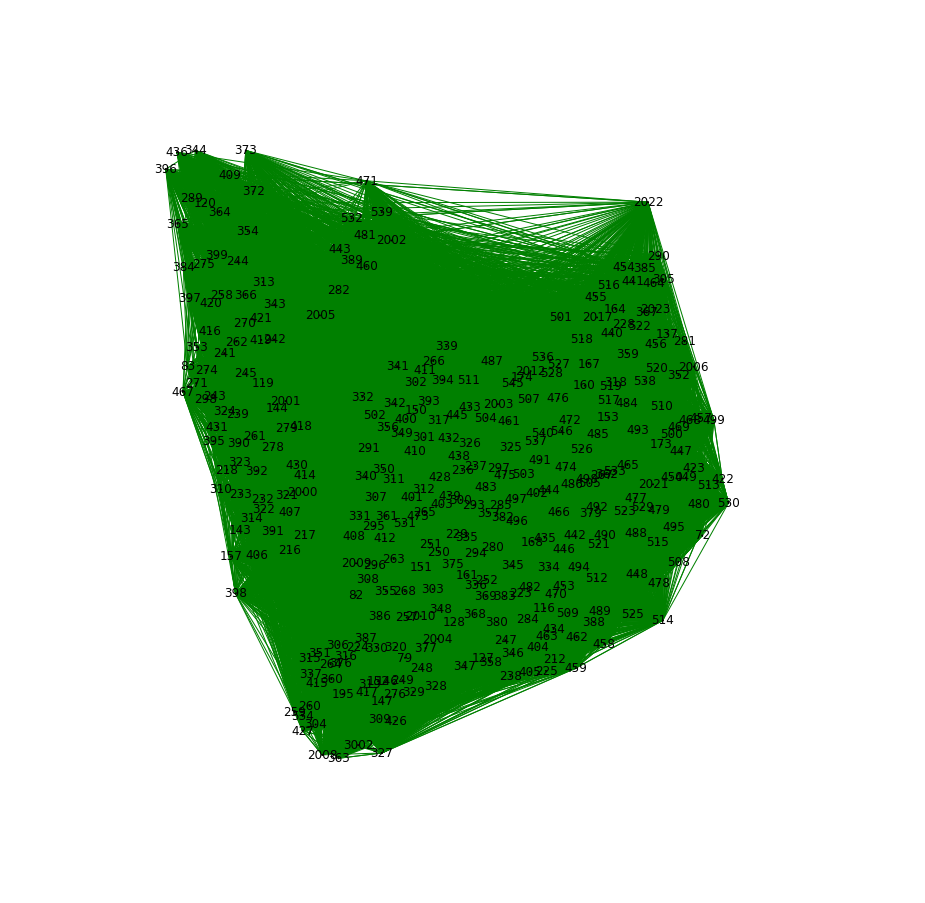

In [20]:
plt.figure(figsize = (12,12))
nx.draw(juneGraph,pos=pos, with_labels=True,arrows=False,node_size=1,width=1,edge_color='green')

In [22]:
nx.set_edge_attributes(juneGraph, 'weight', 0)
for e in juneGraph.edges():
    a=june_averaged[ ((june_averaged['start station id'] == e[0]) & 
                                                      (june_averaged['end station id'] == e[1])) ]['tripduration'].values
    if len(a) !=0:
        juneGraph[e[0]][e[1]]['weight'] = a

In [24]:
#remove loop edges from a network
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU  

In [25]:
#produce symmetrized undirected version of a directed network
def as_undirected(G):
    GU=nx.Graph()
    for e in G.edges(data=True):
        if GU.has_edge(e[0],e[1]):
            GU[e[0]][e[1]]['weight']=GU[e[0]][e[1]]['weight']+e[2]['weight']
        else:
            GU.add_edge(e[0],e[1],weight=e[2]['weight'])
    return GU   

In [27]:
#partition Karate Club network using Louvain method
juneGraphUni = remove_loops(juneGraph)
juneGraphUni = as_undirected(juneGraphUni)
juco = community.best_partition(juneGraphUni)

In [36]:
#visualize network partitioning given node locations pos
def visualizePartition(G,partition,pos):
    N=len(G.nodes())
    s=4+4*int(log10(N))
    plt.figure(figsize=(s,s))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
    nx.draw(G,pos=pos,with_labels=True,arrows=True,node_size=300,node_color=c,width=1,edge_color='black')

In [38]:
# juco

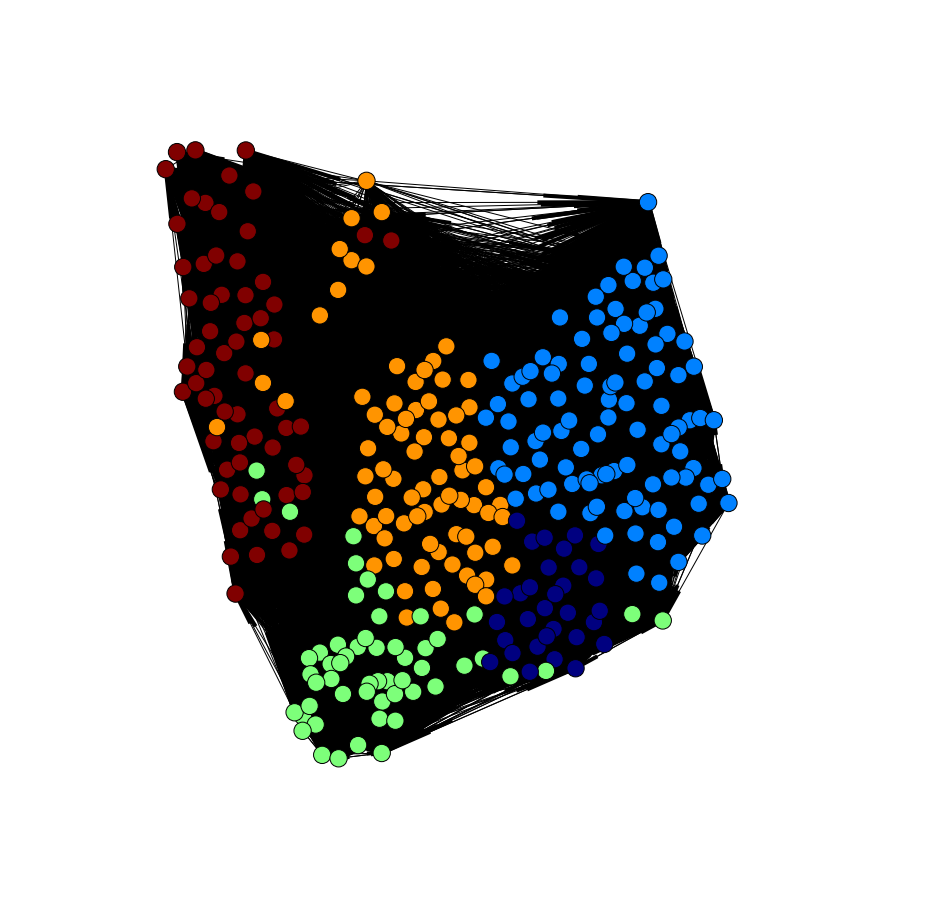

In [35]:
random.seed(2015)
visualizePartition(juneGraph,juco,pos)